Previously, I explored this relationship using Bayesian statistics to suggest that calling a timeout either has no effect on or even decreases the probability of runs ending. This analysis had some flaws, largely because 1. the criteria for "ending" a run are unclear, and 2. there are so many timeouts in college basketball that the prior probability of a run ending was perhaps inaccurate (in that work, two timeouts called without the slipping team returning to trading scores). 

To address these issues, I looked to a method that requires no parameterization to determine when a run is considered over. 

### "Call a daggum timeout!"

-Roy Williams, probably never

## Abstract

This work explores the expected values of timeouts in college basketball to show that calling a timeout when the other team is on a run does not have a better outcome than not calling a timeout. The results even suggest that timeouts of any kind result in more points for the running team.


## Introduction

Basketball fans generally believe that calling timeouts can slow or stop scoring runs. Some coaches (famously, Roy Williams) are criticized for not calling timeouts when their teams are on the wrong side of a scoring run (referred to as the "slipping" team in this work). Fans can be insistent that timeouts <i>must</i> be called in these situations. However, to the best of my knowledge, this general wisdom has never been tested nor supported by any actual analysis. 

Here, we use the expected values of timeouts to determine if they have the purported effect. That is, if a timeout is called, we can look at the average change in score over the next few possessions (the expected value) and compare that value with the average score of a similar run when no timeout was called (or a different type of timeout was called). Briefly, scoring runs are categorized by their point values and divided based on the "terminating" event (home timeout, away timeout, official timeout, or score by either team). Then, the expected value (i.e., average score) of the events that occur after the run is calculated. We can then say that a timeout has an expected value that is greater than, less than, or equal to the expected value when nothing is done.

In this work, we will show the following:

1. There is no correlation between the length of a run and the expected change in score over the next few baskets. The effect of calling a timeout is nearly independent of the previous scoring sequence (i.e., there is a flat line between run length and expected value). In other words, the expected value of a timeout is constant, regardless of the size of a run. N.B.: There is a noticeable Home Court advantage, which is observed as a constant offset.

2. There is no evidence for any kind of settling or momentum effect due to calling a timeout.

3. We can safely reject the null hypothesis that calling a timeout is better than not calling a timeout.

After all, both teams get to use the timeout, why wouldn't the better team also be able to rest and improve their strategy?


## Background

Scoring runs are expected in any contest just by chance. This can easily be seen from simple coin flips. If a team is expected to convert 50% of their possessions (equivalent to a coin flip), then they can be expected to convert several in a row while the other team converts none. In this way, scoring runs should occur in most basketball contests. In the same way, these scoring runs should be expected to end naturally. After a scoring run starts, it should have a predictable probability of ending due to the same effects of chance that created the run.

The most common reason that fans believe timeouts should be called is settling "frazzled" players or slowing momentum. However, if runs are expected statistical results, these intangible factors should not receive much consideration. Players should be expected to recognize these "slumps" and "streaks" as statistically probable events and know how to handle them. I would even suggest that experience with these events, i.e., "playing through" a cold streak or weathering runs towards the ends of games, results in increased overall win percentage and, in particular, improved post-season success. Excessively calling timeouts could result in some pretty bad losses when you really need a timeout. <a href="https://youtu.be/7HhZBaCAa80?t=702">Here's a nice example.</a>

<b>Disclaimer: This is an exercise in statistics and web scraping. I do believe that there are mental components to athletic contests and that scoring is not independent of these factors. However, I think that a coach could easily teach their team to not expect or wait for timeouts in the case of runs, and it would not have a negative effect on their performance. Some of that practice time has to be spent on recognizing the mistakes you are making and correcting them without a timeout.</b>


In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script><h3><b>The raw code for this Jupyter notebook is hidden by default for easier reading.
To toggle the raw code on/off, 
<a href="javascript:code_toggle()">CLICK HERE</a>. 
Some of the analysis may be a bit disjoint without the comments in the code. If you are
comfortable reading Python, consider viewing the code, although it can be a bit long at times.</b></h3>''')


## Methods

In this analysis, we match exact scoring/timeout sequences to other sequences and determine the scores of each team after those sequences. Briefly, the method consists of converting scores into a code "H" or "A" indicating "Home" or "Away" followed by the value of the basket (1-3) or a "T" for "Timeout" ("OT" for "official" or "TV" timeouts). This method produces a string like "H2H2H2A2H2OTATH2A2H3OTHTH1H1A2". We then use a regular expression search to find all sequences that look like runs (i.e., consecutive scores by a team). We use this approach to examine all possible "run" sequences (including a single point). We exclude any sequences that cross into the last 90 seconds of a period because clock management and fouling become very import strategic elements, and those sequences are considered to be part of a separate population with different behaviors. That is, I don't think calling a timeout in the last 30 seconds is the same strategic choice as calling one to end a run during the 10th minute. I have not verified this claim, and it is something I'd like to look into in the future.

After finding sequences that match the run criteria, we divide the runs based on the event that ended the run (TO by type, including no TO) and record the next 4 scores. While I believe multiple timeouts should be considered a "failure" for the slipping team, we ignore any additional TOs to keep this analysis simple and clear. We are comparing sequences to see how calling a timeout *in a particular moment* differs from not calling a timeout. It may be worth investigating multiple timeouts or runs that span timeouts in the future.

In [33]:
# Here, we define some functions that are used throughout the analysis.
# It may be more interesting to read this code when you run across the 
# function calls below.

# Imports
import csv, sqlite3, re 
from collections import defaultdict
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scp

from sklearn.linear_model import LinearRegression 

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16,
                    'figure.figsize': (10, 5)})

# There are some deprecation warnings and not enough values
import warnings; warnings.simplefilter('ignore')

# Intermediate data are stored in human readable format using these functions
def read_dict(filename):
    """
    Opens the indicated filename and creates a list line by line using the first entry on each line
    as the key and the second as the value
    """
    dictionaryoutput = {}
    with open(filename, encoding='latin-1') as file:
        entries = csv.reader(file)
        for item in entries:
            dictionaryoutput[item[0]] = item[1]
    return dictionaryoutput

def write_dict(outputfilename, dictionary):
    """
    Writes a dictionary to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        for key, value in dictionary.items():
            outfile.write('%s,%s\n' % (key, value))
            
def write_list(outputfilename, list):
    """
    Writes a list to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        itemwriter = csv.writer(outfile, delimiter=",")
        for item in list:
            itemwriter.writerow(item)
            
def read_list(filename):
    """
    Opens the indicated filename and creates a list line by line
    """
    listoutput = []
    with open(filename) as file:
        entries = csv.reader(file)
        for item in entries:
            listoutput.append(item)
    return listoutput

def find_run_value(key):
    """
    Takes a sequence of scores (e.g., 'H1H2H2H3H2') and determines the total value of that
    squence. Used to combine different score sequences based on the magnitude of the run.
    
    Values are positive for home streaks and negative for away streaks.
    
    INPUT: String of scoring events
    OUTPUT: Int
    """
    # Determine sign Home is positive Away is negative
    if 'bcdefgijklmnopqrstuvwxyz4567890' in key.lower():
        # Should provide a bit of security for the eval() below.
        raise ValueError('Key contains invalid characters: {}'.format(key))
    elif 'H' in key and 'A' in key or 'T' in key:
        raise ValueError('Mixed key: {}'.format(key))
    elif 'H' in key:
        sign = 1
    elif 'A' in key:
        sign = -1
        
    ##key = key.replace('A', '+').replace('H', '+')
    ##
    ### TODO: should be able to get rid of sign and just change this to A -> - H -> +
    ##
    # Nifty way to determine the score of the sequences
    key = key.replace('A', '+').replace('H', '+')
    # Functionally evaluates the string 
    # (This is dangerous, but I've always wanted to use it)
    # I wouldn't set this up in a publically available place
    run_value = eval(key) * sign 
    # More error checking shouldn't be possible but whatever.
    if run_value == 0:
        raise ValueError("Score streak evaluated to 0. Key: {}".format(key))
    return run_value

def find_sequence_value(seq, scores=4):
    """
    Counts the first 'scores' scoring events in a sequence, ignoring timeouts and neglecting the
    error checking of find_run_value. If tehre are fewer than 'scores' events, the run is discarded.
    
    INPUT: 
        seq = string of events
        scores = int indicating number of scoring events to count. 
    OUTPUT: 
        seq_value = int showing value of sequence
        seq_value_less_one = int of value of sequence with scores-1 events
                            used to check for parity in supporting info
    """
    seq_value = 0
    for c in seq:
        # If it's a timeout or indicating an official timeout, skip
        if c in 'OT':
            continue
        # Set the sign
        elif c == 'A':
            sign = -1
        elif c == 'H':
            sign = 1
        # Add the score with the appropriate sign
        # Will only reach this point if 
        else:
            scores -= 1
            seq_value += sign * int(c)
        if not scores:
            # Return sequence value and sequence minus the last value (looking for parity dependence)
            return seq_value, seq_value - sign * int(c)
    # This will return None if a sequence does not have a length >= scores
    return None

# Make a dictionary that improves readability of the output
to_abr = {
            'NoT' : 'No Timeout',
            'OT' : 'Off. Timeout',
            'HT' : 'Home Timeout',
            'AT' : 'Away Timeout',
            'ZT' : 'Zero Timeout'
        }
    
    
def set_default(runner, min_score, max_score):
    """
    Sets default score ranges if no score is provided. Simplifies
    the plotting process somewhat.
    
    INPUT: 
        runner = string indicating team that is running
        min_score, max_score = ints indicating min and max of range
                                if None, default will be inserted
    OUTPUT: 
        min_score, max_score (ints will be passed unchanged)
    """
    
    if runner not in 'HomeAway':
        raise ValueError('Ineligible team name (check capitalization):', runner)
    
    # Set default score range
    # Done here so simplify Home/Away selection
   
    if runner=='Home':
        if not min_score:
            min_score = 4
        if not max_score:
            max_score = 11
        else:
            max_score += 1 # Values aren't inclusive, this makes function use more intuitive
    else:
        if not min_score:
            min_score = -10
        if not max_score:
            max_score = -3 # not inclusive
        else:
            max_score += 1
            
    return min_score, max_score

def _get_significance(pval, tval, runner, alpha):
    """
    Helper function to get significance based on results in t_test.
    
    See t-test below
    """
    sig_b = 'Accept'
    sig_w = 'Accept'
    if runner == 'Home':
        if tval < 0:
            p_null = 1 - (pval/2) 
            p_w = pval/2  
            if p_w < alpha:
                sig_w = 'Reject'
        elif tval > 0:
            p_w = 1 - (pval/2)
            p_null = pval/2
            if p_null < alpha:
                sig_b = 'Reject'
    elif runner == 'Away': # For clarity
        if tval < 0:
            p_w = 1 - (pval/2)
            p_null = pval/2
            if p_w < alpha:
                sig_w = 'Reject'
        elif tval > 0:
            p_w = pval/2
            p_null = 1 - (pval/2)
            if p_null < alpha:
                sig_b = 'Reject'
                
    return p_null, sig_b, p_w, sig_w

def t_test(to_1, to_2, score_dictionary, runner='Home', alpha=0.05, \
           min_score=None, max_score=None, bonferroni=False):
    """
    Performs Welch's t-test to determine if to_1 is signficantly 'better'
    than to_2, where 'better' is determined by the 'runner' and the team
    that wants improvement is the opposite team. That is, if runner='Home',
    we are testing the null hypothesis that to_1 < to_2, which is the case
    where the expected value of the to_1 results in more points to the away
    (slipping) team and vice versa.
    
    INPUT: 
        to_1, to_2 - strings indicating timeout keys
        alpha - float of significance level
        bonferroni - bool indicating whether to perform bonferroni correction
            
    OUTPUT: 
        table of t-statistics and corresponding p-values for each run length 
        betweeen min_score and max_score. Significant better and significant
        worse are included indicating results for both the original H0 and the
        counterintuitive result where timeouts hurt the running team
    """

    to_1_scores = []
    to_2_scores = []
    
    if not min_score or not max_score:
        min_score, max_score = set_default(runner, min_score, max_score)
        
    if bonferroni:
        alpha = alpha/abs(max_score - min_score)
        
    # Apply readability labels
    to_1_nick = to_abr.get(to_1, to_1) #else just use the code
    to_2_nick = to_abr.get(to_2, to_2)
    
    slipper = 'home' if runner == 'Away' else 'away'
        
    if runner == 'Home':
        print('H0: Expected value of {} >= expected value of {}'.format(to_1_nick, to_2_nick))
        print('HW: Expected value of {} > expected value of {}'.format(to_1_nick, to_2_nick))
        is_reversed = False
    elif runner == 'Away':
        print('H0: Expected value of {} > expected value of {}'.format(to_1_nick, to_2_nick))
        print('HA: {} is not signficantly different or worse for the {} team than {}'.format(to_1_nick, slipper, to_2_nick))
        print('HW: Expected value of {} < expected value of {}'.format(to_1_nick, to_2_nick))
        is_reversed = True
    else:
        raise ValueError('Invalid team {}'.format(runner))
    print('--------------------------------------------------------------------')
    print('run length | t-stat | H0 p-value |  H0?   | HW p-value |  HW?')
    print('--------------------------------------------------------------------')
    for run_length in sorted(range(min_score, max_score), reverse=is_reversed):
        try:
            to_1_scores.extend(score_dictionary[(run_length, to_1)])
            to_2_scores.extend(score_dictionary[(run_length, to_2)])
            tval, pval = scp.ttest_ind(score_dictionary[(run_length, to_1)], \
                            score_dictionary[(run_length, to_2)], equal_var=False)
        except KeyError:
            continue
        
        p_null, sig_b, p_w, sig_w = _get_significance(pval, tval, runner, alpha) 
        print('      {:<3}  | {:+.3f} |    {:.3f}   | {} |    {:.3f}   | {}'.format(run_length, tval, p_null, sig_b, p_w, sig_w))
    
    # Finally print the t-test results if we assume independence
    print('--------------------------------------------------------------------')
    tval, pval = scp.ttest_ind(to_1_scores,to_2_scores, equal_var=False)
    p_null, sig_b, p_w, sig_w = _get_significance(pval, tval, runner, alpha)
    print(' Full Set  | {:+.3f} |    {:.3f}   | {} |    {:.3f}   | {}'.format(tval, p_null, sig_b, p_w, sig_w))
    
    
def plot_averages(to_types, score_dictionary, min_score=None, max_score=None, runner='Home',\
                  ylim=(-1,1), full_summary=False):
    """
    Helper function to plot the average scores.
    """
    
    if not min_score or not max_score:
        min_score, max_score = set_default(runner, min_score, max_score)

    for to in to_types:
        xs = []
        ys = []
        sem = []
        for run_length in range(min_score,max_score):
            # Might not have values for every point value in the range.
            # If there's no value, skip ahead
            try:
                ys.append(score_dictionary[(run_length, to)].mean())
                sem.append(score_dictionary[(run_length, to)].std() / \
                               np.sqrt(len(score_dictionary[(run_length, to)])))
                xs.append(run_length)
            except KeyError:
                continue
        # print('Expected value of {}:\t\t{:.2f} +/- {:.2f}'.format(to_abr[to], (sum(ys)/(len(ys)-1)), np.array(ys).std()))
        lr = sm.OLS(ys, [[x,1] for x in xs], hasconstant=True).fit()
        #dir(sm.OLS([1,2,4],[3,4,5]).fit())
        
        # Try to apply readability labels
        to = to_abr.get(to, to) #else just use the code
        
        if full_summary:
            print(lr.summary())
        else:
            print('{} p-value slope is non-zero: {:.3f}'.format(to, lr.pvalues[0]))
            if lr.pvalues[0] < 0.05:
                print('{} coeff: {:.3f}'.format(to, lr.params[0]))
        plt.errorbar(xs, ys, yerr=sem, fmt='o', label=to)

            
    # Subtract one here to make plot more appealing.
    plt.plot((min_score-1, max_score), (0, 0), 'k-') # Add line at zero
    plt.xlim(min_score-1, max_score)
    plt.ylim(ylim[0], ylim[1])
    plt.title(runner + ' Run Size vs. Change in Score Margin')
    plt.xlabel('Run Size')
    plt.ylabel('Change in Score Margin After Run End')
    plt.legend(loc='lower right')
    if runner=='Away':
        plt.gca().invert_yaxis()
        plt.gca().invert_xaxis()
    plt.show
        

# These dicationaries are created during scraping
# They basically serve to convert 'actor id' into team name
# or abbreviations into to team names. These abbreviations and
# ids are internal ESPN codes that are scraped directly.
ABRDict = read_dict('./ESPN_scraper/ABRdictionary.csv')
NUMDict = read_dict('./ESPN_scraper/NUMdictionary.csv')

#game_sequences = read_list('./data/game_sequences.csv')

print('This deprecation warning (if it appears) can be safely ignored for now.')

This deprecation warning (if it appears) can be safely ignored for now.


In [3]:
# Get data from the DB.
conn = sqlite3.connect('./data/CBBdb.sqlite3')
curr = conn.cursor()

# Exclude bad data
# It might be possible to salvage some of these games as they were frequently a single line where the
# points were added to the wrong team and corrected on the next line. Some games were excluded because
# ESPN did not have labels for them. These games were universally blowouts against very small schools and I think
# it best that they are not included anyway as they are not representative of competitive college games.
# It should be possible to impute this information, but I don't think it would have a meaningful effect on the
# outcomes.

# Games can be plugged into http://www.espn.com/mens-college-basketball/playbyplay?gameId=$game_id$ 
# or #data.loc[(data.game_id == $game_id$)] to view original data.
data = pd.read_sql_query("""SELECT *
                        FROM playbyplay
                        WHERE game_id not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633', '303172239', '290450275',
                        '280472483', '283472390', '290450275', '290650087', '293170041', '260280218', '263240150', 
                        '270170222', '400498526', '400591228', '273332603', '310630171', '253190235', '253532250', 
                        '260020150', '253180142', '253340120', '253422250', '260072608', '260120204', '260230221',
                        '260282507', '260282294', '260310275', '260360152', '263240096', '263330221', '263330264',
                        '263400057', '263572305', '270090275', '270130062', '270152305', '270150097', '270160254',
                        '270232390', '270272305', '270380201', '270460012', '270462509', '270550079', '270672440',
                        '270670120', '273212501', '273512250', '273532086', '280030305', '280050103', '280430258',
                        '280562306', '280590097', '280612181', '280612181', '280660356', '280730235', '283310153',
                        '283402181', '283420052', '290092561', '290350026', '290452752', '290490235', '400869965',
                        '290530183', '290592550', '290660277', '293130153', '293160194', '293172509', '293200041',
                        '293290012', '293392509', '293410251', '293540059', '300090167', '300300096', '303120356',
                        '303160127', '303160062', '303170068', '303172181', '303170036', '303180150', '303180084',
                        '303200097', '303250152', '303300222', '303310251', '303320127', '303360239', '303390030',
                        '303452350', '303480251', '303500142', '303520082', '303580326', '310052633', '310070315',
                        '310090150', '310122599', '310120046', '310120142', '310150145', '310200264', '310350163',
                        '310360097', '310562099', '313160275', '313310221', '313500140', '320140077', '320490305',
                        '323280057', '323300038', '323330156', '330012506', '330712065', '400498358', '400502811',
                        '400507286', '400545134', '400597751', '400589302', '400589302', '400585776', '400586395',
                        '400835654', '253252124', '253262124', '263242124', '273152306', '273302413', '273232124',
                        '283202390', '283270221', '283292124', '283402567', '293190130', '293272124', '400856728',
                        '400841076', '400847079', '400840829', '400833168', '273170026', '273192305', '313500085',
                        '400840099', '313462885', '323652413', '313502751', '303172348', '313462542', '303160349',
                        '300300059', '303162545', '313530239', '400595223', '303160006', '303170055', '400591595',
                        '400817510', '293282124', '400589303', '303262124', '303160151', '303172184', '293512026',
                        '273192305', '400833387', '323650324', '400591290', '303160155', '273210245', '303172169',
                        '303172751', '400588668', '303170357', '400587424', '323652309', '303172086', '293432250',
                        '323652908', '400498590', '400586319', '400590746', '293512166', '323652750', '400840168',
                        '400499958', '273170026', '400513943', '303332306', '400591223', '303160140', '323482439',
                        '400588669', '303182619', '323490013', '400830619', '303162674', '400595362', '323650193',
                        '323652427', '303172515', '400504241', '400586918', '303172737', '323372272', '400818872',
                        '400505535', '303650021', '300070043', '313390050', '303172275', '303160338', '303182515',
                        '313500331')""", conn)
conn.close()
#del data['rowid'] # Redundant with pandas index.
# Ensure that numbers are numeric values and not strings.

data = data.apply(pd.to_numeric,errors='ignore')

In [4]:
print('The data are stored in an SQL database with the format below.\n' +\
      'There are {} events across {} games.'.format(len(data), len(data.groupby('game_id'))))
# game_id :  ESPN gameid number
# date : date that the game was played
# event_index : sequence of play by play event
# time : remain time in period
# actor : ESPN code for team
# event : written description of the play
# away, home, away_score, home_score, what you would expect
data.head(3)

The data are stored in an SQL database with the format below.
There are 1631366 events across 5250 games.


,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
0,253120183,2005-11-09,0,1194,183,Darryl Watkins missed Two Point Layup.,BCU,SYR,0,0
1,253120183,2005-11-09,1,1176,183,Louie McCroskey made Three Point Jumper.,BCU,SYR,0,3
2,253120183,2005-11-09,2,1154,2065,Cleveland Williams missed Two Point Jumper.,BCU,SYR,0,3


In [5]:
# We need to divide games into periods so that we don't span halftime,
# overtime periods or different games. ESPN doesn't mark this difference,
# so we use the time restart (i.e., t2 > t1 where t is decreasing) to indicate 
# the start of a new period or an out of order event (i.e., bad game data).

# CONSIDER using groupby to split the games. Might be faster.
# https://stackoverflow.com/questions/28911119/split-dataframe-into-two-or-more-

# Add each half/ot to periods list
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():
    time = row['time']
    if time > lasttime + 1:
        period = data[lastindex:i]
        period['game_id'].values[0]
        periods.append(data[lastindex:i])
        lastindex = i
    lasttime = time
    
#Add the last period
periods.append(data[lastindex:i])

We transform the above data into a string for each period containing only scoring plays and timeouts. An "H" indicates "Home", "A" indicates "Away", and "O" indicates "Official" or "TV". The number indicates the point value of the play (i.e., 1 is a free throw, 3 is a three pointer). "T" is a timeout.

An example game is shown below:

In [6]:
# Now, we transform the data into strings of scores and timeouts.
# I used a string conversion here because regex made this analysis
# easier and it's an easy way to see all of the important events
bad_games = [] # Store bad games and remove them during SQL query - should be empty
game_sequences = [] # List of all of the game sequences
last_game_id = -1
for period in periods:
    game_id = period.game_id.values[0]
    game_sequence = ''
    # We carry the halftime/overtime score and reset on a new game 
    if game_id != last_game_id:
        last_home = 0
        last_away = 0
    for i,row in period.iterrows():
        # Excluding last 90 seconds
        if row.time < 90:
            break
        points = (row.home_score - last_home) - (row.away_score - last_away)
        # We need to make sure that the sequence is accurate, otherwise 2 digit scores throw off the analysis
        if points > 3 or points < -3:
            bad_games.append(row.game_id)
            break
        last_home = row.home_score
        last_away = row.away_score
        if 'timeout' in row.event.lower():
            if 'tv' in row.event.lower():
                game_sequence += 'OT'
            if row.actor != -1: # -1 for teams that aren't in the team dictionaries
                if NUMDict[str(row.actor)] in ABRDict[row.home]:
                    game_sequence += 'HT'
                elif NUMDict[str(row.actor)] in ABRDict[row.away]:
                    game_sequence += 'AT'
            else:
                bad_games.append(str(game_id))
                break
        elif points > 0:
            game_sequence += 'H' + str(points)
        elif points < 0: 
            game_sequence += 'A' + str(abs(points))
            
    # Get current values so we can make sure we have the correct starting score 
    last_game_id = game_id
    last_home = period.iloc[-1].home_score
    last_away = period.iloc[-1].away_score
    
    # We could exclude uncompetitive games here (e.g., average score margin > x or final margin > y)
            
    game_sequences.append([game_id, game_sequence])

# Check a random value
print('Gameid: {}\nGame Sequence: {}'.format(*game_sequences[42]))
#print("', '".join(set(bad_games))) # Output bad games in a convenient format for SQL exclusion
#print('The result below should be an empty list "[]" (automatic detection of bad data):\n', bad_games) 

Gameid: 253222250
Game Sequence: H2H2A1A1H2A2A2H2H1H2H2A2ATA3H2H2H2ATH1A3ATA3A2H2ATH2A2OTHTH2A2H2H2A2HTA3OTHTA1H1


In [7]:
# Some of the above is a bit slow so we can read/write here
# Used a csv for readability. Pickle would also have worked.
#write_list('./data/game_sequences.csv', game_sequences)
#game_sequences = read_list('./data/game_sequences.csv')

Next, we use regular expressions to find any runs and the sequences of scores that follow the runs. We define a "run" as any number of consecutive scores (including free throws) by a team. Then, we determine the sequence of events that occurred after that run (e.g., the running team continued to score, teams traded scores, timeouts were called, or the slipping team went on a counter run). We collect these data for the duration of the run and then the following 8 events (scores or timeouts). We require that there be 4 scores within these 8 events or the sequence is discarded: More timeouts than scores seems like a sequence that should be examined further. I believe that multiple timeouts should be considered a "win" for the running team (especially if they are both called by the slipping team), but I have excluded this condition from this analysis because we are interested in the expectation value of a timeout.

As a concrete example, the list printed below shows all of the sequences that occurred after the home team scored three 3pts in a row ('H3H3H3').

In [8]:
# Regex search strings
home_run = """(H[1-3]){1,}"""
away_run = """(A[1-3]){1,}"""
# Change to """(H[1-3]){2,}([AOUT1-3]{2}|HT[HAOUT1-3]{10})""". Should be able to get groups directly 
# and should only find sequences where there are enough events after the run simplifying of the code below

full_run_dictionary = defaultdict(list)
for period in game_sequences:
    for run_seq in [home_run, away_run]:
        for start, end in [(m.start(0), m.end(0)) for m in re.finditer(run_seq, period[1])]:
            # The regex does not find overlaps but we want to make sure that we are unbiased in defining what
            # happens next under certain circumstances, so we need to collect subsequences of longer runs.
            # As an example, a sequence like H2H3H2H1H1H3H2 will only match once, but we also want to consider
            # H2H3H2 as a run. The regex will find H2H3H2(A[1-3T]|HT) but we need to include the possibility that
            # the run continues. The loop below will add repeatedly for subsequences
            while end - start >= 2:
                run = period[1][start:end]
                sequence = period[1][end:end+16] # Only take 8 events to limit sequences 
                # Need at the very least 8 characters for 4 scores
                if len(sequence) >= 8:
                    full_run_dictionary[run].append(sequence)
                # Remove the last event and get the shorter sequence
                end -= 2

# This dictionary will be useful if you are interested in finding how specific sequences compare
# For example you may want to know if H3H3 differs from H2H2H2 or even H1H1H2H2, etc.
# Sequences that span timeouts will require modification of the above code.
print(full_run_dictionary['H3H3H3'])

['ATA2H2A3H3A3H3A2', 'H2ATH2A2H2A3OTHT', 'ATH2OTHTA2H3H2AT', 'ATA3H3OTHTH2A2H2', 'ATOTATA1A1A2H3H2', 'ATH2H1A2H2A2H3A2', 'ATA3OTHTH2A2H3H2', 'ATH2OTHTA2H1H2OT', 'ATOTHTH1H1A2H2', 'ATOTATH3A2H3H3AT', 'ATH2H3A2OTATA1H1', 'A2H2A3H3', 'ATA2A2HTOTHTH3A2', 'ATA2H2A2OTHTH3H2', 'H1A1A1OTHTH1H1A2', 'H3A2A1H2OTATA1A1', 'A2H2OTATA2OTATA1', 'A3H2A2HTOTHTH1', 'ATH2OTHTH2A2', 'ATOTATA2H1H1OTHT', 'ATOTHTATH2A2H2A2', 'H1H1OTATH3A1A1H2', 'OTHTH1H2A2HTH2OT', 'H2ATA3H2A2OTATH3', 'H2OTHTH1H2A3H2A2', 'OTATA1A1H2H1H1A3', 'ATA2H1H2OTHTH1H1', 'A2H3A2OTATA2H2H2', 'OTATH3A1A1H2A1A1', 'A1A1H2ATA1A1H2OT', 'ATA2A2H2H2OTATH3', 'H3H2ATOTHTA2H3H1', 'A2H2OTATA1HTH1', 'ATA2OTATA2H2H2A2', 'ATA3H2A2OTHTH1A2', 'A3A1A1H2H2ATH3H3', 'ATOTHTH2H1H1A1A1', 'A1A1H3H2A2H3ATA3', 'ATA1OTATA1H2A3A3', 'A3H2A2H3H2A2H2A2', 'ATA1H2H1A2A1A2H2', 'ATA2H2A3H3OTATA2', 'ATA2HTH2A3OTHTH3', 'OTHTH1A1A1', 'A3H2OTATA1A1H3AT', 'ATA3A2OTATH3A1A1', 'OTHTH2A3HT', 'ATA2OTATH1H1H2A2', 'ATA2A2H2H2H2OTAT', 'H3ATH2OTATA2H1H1', 'ATH2H1H1OTATA1H1', 'ATA1A2H2

There are many possible run sequences (e.g., for 6 points, H3H3, H2H2H2, H3H2H1, H1H3H2, etc.). For simplicity, we are going to start by grouping runs based on value. Some fans might claim that different sequences will "feel" different, and I agree that matching exact sequences is a worthwhile avenue of exploration, but I will leave that exercise to the reader (for now at least - if you are interested in pursuing this line of research, don't hesitate to reach out to me). The data are much sparser in this case, which will require more careful analysis. In any case, the results show that there is no dependence of the expectation value on run length, so I feel fairly confident that there won't be any dependence on run composition either.

Specifically, the values of the run sequences are calculated, and the following sequences are separated based on the "terminating" event (official, home team, away team, or no timeout). **Run values are calculated to be positive for the home team and negative for the away team** so that we can easily correlate run continuation or ending based on the sign and magnitude.

A brief summary of the types of sequences is provided below:

In [9]:
# Here we find out how much each sequence is worth and the value of the scores after the timeout
# We produce a list of [run_sequence, value of run, [lists of values of post TO sequences by type of timeout]]
# that is, [no timeout, all timeouts, official timeout, home timeout, away timeout]
score_histories = []
total = 0
not_enough = 0
multiple_t = 0
for key in full_run_dictionary:
    run_value = find_run_value(key)
    # We collect all of the '-1' sequences so we can determine if there is some
    # parity bias (i.e., even or odd number of trailing scores)
    seq_values = {'NoT': [],
                'NoT-1': [],
                'HT': [],
                'HT-1': [],
                'AT': [],
                'AT-1': [],
                'OT': [],
                'OT-1': [],
                'ZT': [],
                'ZT-1': []}
    
    for seq in full_run_dictionary[key]:
        total += 1
        if len(re.findall(r'T', seq)) > 1:
            multiple_t += 1
            # We could consider breaking here to only look at sequences with 1 timeout
        # Find values of the runs
        # If a sequence is too short (i.e., near the end of the period) don't count it and skip ahead
        try:
            # find_sequence_value returns None if the sequence is too short, giving a TypeError
            # 'NoneType' object is not iterable
            seq_value, seq_v_less1 = find_sequence_value(seq, scores=4)
        except TypeError:
            not_enough += 1
            continue
        # Sort sequences based on whether a TO was called and who called it
        if 'T' not in seq: # No timeouts called anywhere
            seq_values['ZT'].append(seq_value)
            seq_values['ZT-1'].append(seq_v_less1)
        caller = seq[0] if seq[1] == 'T' else 'No'
        seq_values[caller + 'T'].append(seq_value)
        seq_values[caller + 'T-1'].append(seq_v_less1)
    # Adds the above calculated and divided values to a list.
    score_histories.append([key, run_value, seq_values])
        
print("Number of run types:", len(score_histories))
print("Total runs:", total)
print("Runs crossing into last 90 seconds:", not_enough)
print("Post-run sequences with multiple timeouts:", multiple_t)

Number of run types: 1142
Total runs: 325762
Runs crossing into last 90 seconds: 11091
Post-run sequences with multiple timeouts: 246223


In [10]:
# Collect sequences based on score
combined = defaultdict(list)
for values in score_histories:
    for seq_type in values[2].keys():
        # combined[(score, to type)]
        combined[(values[1], seq_type)].extend(values[2][seq_type])
#After arrays are complete, convert them to np.array to make calculation of mean faster and easier
np_combined = {}
for k,v in combined.items():
    np_combined[k] = np.array(v)

In [11]:
#print('Available TO types:', seq_values.keys())

## Results

The plots below show the change in score margin against the size of the run. The x-axis shows the size of the run, and the y-axis shows the change in score margin after the next 4 scores. The sequences are grouped by the event that terminated the run, i.e., No TO (a score by either team), Away TO, Home TO, or Official TO). A line is drawn through zero as a guide to separate running/home team advantage (positive score margins) and slipping/away team advantage (negative score margins). Initially, we will only show the home team, but as will be discussed later, the same analysis applies to runs by the away team.

A few important notes:

1. The range is shown for 4-10 points. Games rarely have scoring runs exceeding 10 points due to the frequency of official timeouts. Importantly, we need to be careful when we have too few samples because our approximation that the distribution of the dependent variable is continuous and normal fails. To help easily identify these situations, the standard error of the sampling mean is included as y-error bars. Most of the data points have enough samples for the error bars to be within the data point, but one can clearly see that some samples have very high uncertainly.

1. "Runs" of length 1 are a bit odd due to the high bias of likely shooting another free throw. They should be examined more closely and aren't particularly relevant to this analysis.

1. Similarly, we exclude "runs" of length 2 and 3 as not interesting or relevant to our experiment. The code is quite amenable to changing ranges if one so desires to explore these cases. As an aside, single 3pts appear to have an effect on initiating runs, which may be worth future examination. I did not examine these observation at the time as I had no properly established hypothesis.

1. There is an obvious home-court advantage that is particularly evident when the away team is on a run.


## Runs by the Home Team

### No Timeout and Showing Independence

First, we show sequences where no timeout was called. The first observation is that the line is roughly flat. Using a significance level of 0.05, we can assert that the slope is not statistically different from 0 (H0: $\beta_1$ = 0 with p = 0.251, so we fail to reject the null hypothesis). Summary statistics are shown in the table below. For our purposes, only "P>|t|" for "x1" (the p-value used to reject the null hypothesis if it is below the significance level) is relevant and is the only quantity reported elsewhere.

A flat line indicates that there is no correlation between the length of a run and the expected value of not calling a timeout. That is, the effect of not calling a timeout does not change as the length of the run changes. Sequences where no timeout was called serve as the baseline because we want to compare identical sequences with and without timeouts to determine if the timeout had an effect. N.B.: We do not "look ahead" into the future to see if a timeout is called after another point or two as that would be adding information to the sequence that we do not have when the timeout is called. These cases were explored, and the results are worse for the slipping team if we only consider runs with no timeouts at all (see Supporting Information).

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.685
Date:                Wed, 28 Feb 2018   Prob (F-statistic):              0.251
Time:                        13:34:15   Log-Likelihood:                 10.162
No. Observations:                   7   AIC:                            -16.32
Df Residuals:                       5   BIC:                            -16.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0164      0.013      1.298      0.2

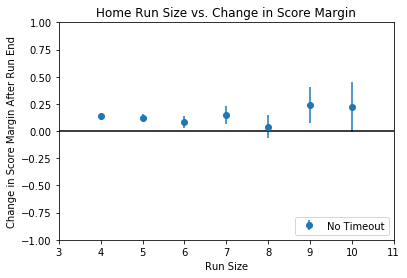

In [12]:
plot_averages(['NoT'], np_combined, full_summary=True)

### Official Timeouts

We begin our analysis with official timeouts because these results are easier to see and interpret intuitively. Official timeouts (OTs) are very informative because possession is effectively random, so we can avoid bias due to  teams setting up scoring plays, thus easily rejecting the weakest claim of most basketball fans that any time stoppage is good for the slipping team. The figure below shows the expected change in score margin for runs that end with no timeout (blue) and official timeouts (orange). As can be seen, the orange points are always above the blue points, suggesting that the home/running team scores more points after an OT than during similar sequences without a timeout. Thus, an OT provides an ***advantage to the home/running team***. The slope of the best fit line is once again not statistically significant, as indicated by the p-value.

No Timeout p-value slope is non-zero: 0.251
Off. Timeout p-value slope is non-zero: 0.193


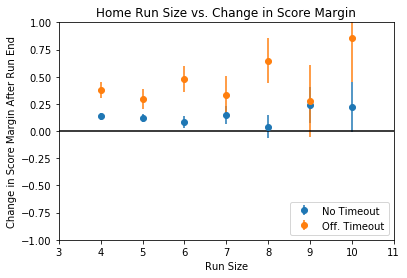

In [13]:
plot_averages(['NoT', 'OT'], np_combined, full_summary=False)

## T-test for statistical significance

Now, we perform t-tests to determine whether we should believe that timeouts help the slipping team. Intuitively, the results show that if the home/running team scores more with official timeouts than with no timeouts, the official timeout is bad for the away/slipping team. First, we need to establish a null hypothesis (H0) because we can't really prove anything, only say that, to some confidence level, the the null hypothesis is false.

In this case, we want to reject the null hypothesis which claims "timeouts help the slipping team". In a mathematical framework we say "when the home team is on a run, the expected value of an away timeout is significantly lower than that of no timeout" or AT < NoT (recall that away scores are represented by negative values, so closer to zero or more negative is better for the away team). Equivalently, for a run by the away team, "when the away team is on a run, the expected value of a home timeout is significantly greater than that of no timeout" or HT > NoT.

The results of these tests are shown in the tables below with specific hypotheses written out. H0 is the initial null hypothesis (generally, that timeouts are good for slipping teams). HA is the hypothesis we should accept if we reject the null hypothesis. I have also included HW, which is the hypothesis that timeouts are actually ***WORSE*** for the slipping team. This hypothesis should be taken somewhat with a grain of salt as it is a post-hoc analysis.

The table is divided into two portions for illustrative portions (and for potential future users). If we trust the result that run length and expected value are independent (which we should) only the bottom line is important because we perform our hypothesis test using the entire population. However, I've included independent results in case someone wants to consider them independently.

For the interpretation of the table below, we use the same hypothesis as for away timeouts (OT < No Timeout) under the assumption that the greatest contributor to runs is "frazzled", lost, or tired players: If calling a timeout serves to "settle" players, an official timeout should be just as effective as a "slipping" timeout. However, the results show that ***official timeouts significantly hurt the slipping team*** with p < 0.001. This result seems to completely destroy the idea that any stoppage helps the slipping team and that discombulated players are the reason for runs. This effect holds even when the away team is on a run (*vide infra*)!

In [36]:
t_test('OT', 'NoT', np_combined, runner='Home', bonferroni=False)

H0: Expected value of Off. Timeout < expected value of No Timeout
HA: Off. Timeout is not signficantly different or worse for the away team than No Timeout
HW: Expected value of Off. Timeout > expected value of No Timeout
--------------------------------------------------------------------
run length | t-stat | H0 p-value |  H0?   | HW p-value |  HW?
--------------------------------------------------------------------
      4    | +3.142 |    0.001   | Reject |    0.999   | Accept
      5    | +1.837 |    0.033   | Reject |    0.967   | Accept
      6    | +3.059 |    0.001   | Reject |    0.999   | Accept
      7    | +0.930 |    0.176   | Accept |    0.824   | Accept
      8    | +2.606 |    0.005   | Reject |    0.995   | Accept
      9    | +0.104 |    0.459   | Accept |    0.541   | Accept
      10   | +1.364 |    0.087   | Accept |    0.913   | Accept
--------------------------------------------------------------------
 Full Set  | +5.184 |    0.000   | Reject |    1.000   | Acce

### Home/Runner Timeout

There are very few examples of the running team calling timeouts, as can be seen from the error bars. However, we can still safely reject the null hypothesis (HT < NoT) and even accept the counter argument HT > NoT. This example is not particular interesting for our study, but included for completeness.

No Timeout p-value slope is non-zero: 0.590
Off. Timeout p-value slope is non-zero: 0.791
Home Timeout p-value slope is non-zero: 0.535


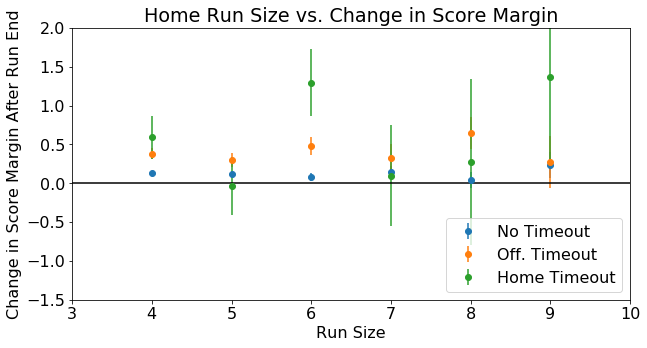

In [37]:
plot_averages(['NoT', 'OT', 'HT'], np_combined, ylim=(-1.5,2), max_score=9)
#plot_averages(seq_values.keys())

In [38]:
t_test('HT', 'NoT', np_combined, runner='Home', bonferroni=False, max_score=9)

H0: Expected value of Home Timeout < expected value of No Timeout
HA: Home Timeout is not signficantly different or worse for the away team than No Timeout
HW: Expected value of Home Timeout > expected value of No Timeout
--------------------------------------------------------------------
run length | t-stat | H0 p-value |  H0?   | HW p-value |  HW?
--------------------------------------------------------------------
      4    | +1.651 |    0.051   | Accept |    0.949   | Accept
      5    | -0.405 |    0.657   | Accept |    0.343   | Accept
      6    | +2.765 |    0.004   | Reject |    0.996   | Accept
      7    | -0.070 |    0.527   | Accept |    0.473   | Accept
      8    | +0.214 |    0.416   | Accept |    0.584   | Accept
      9    | +0.910 |    0.196   | Accept |    0.804   | Accept
--------------------------------------------------------------------
 Full Set  | +1.901 |    0.029   | Reject |    0.971   | Accept


### Away/Slipper Timeout

Okay, okay, "What about the slipping/away teams!?" you ask. Well, as shown below, we can easily reject the null hypothesis. At best, calling a timeout is no different from not calling a timeout. As briefly mentioned above, I'd also speculate that coaches are well aware of most of what we've presented here and only call timeouts when they have a specific change to make or a specific play to run. That is, the momentum killing or desperation timeouts already aren't being called.

If we consider these runs independently the "statistically significant" result is that for 8-point runs, calling a timeout is worse for the away/slipping team. If we apply a correction for multiple comparison tests (i.e., Bonferroni correction), this effect disappears, as expected (<a href='https://www.xkcd.com/882/'>relevant XKCD</a>). Note the large error bars on the 9- and 10-point runs: There are too few examples of these runs for our assumptions to hold true, so very little weight should be given to them (see Supporting Information).  

No Timeout p-value slope is non-zero: 0.251
Away Timeout p-value slope is non-zero: 0.293


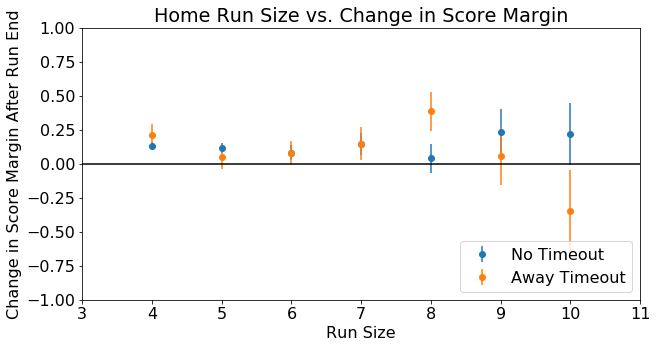

In [39]:
plot_averages(['NoT', 'AT'], np_combined,ylim=(-1,1))

In [48]:
t_test('AT', 'NoT', np_combined, runner='Home', bonferroni=False)

H0: Expected value of Away Timeout < expected value of No Timeout
HA: Away Timeout is not signficantly different or worse for the away team than No Timeout
HW: Expected value of Away Timeout > expected value of No Timeout
--------------------------------------------------------------------
run length | t-stat | H0 p-value |  H0?   | HW p-value |  HW?
--------------------------------------------------------------------
      4    | +0.898 |    0.185   | Accept |    0.815   | Accept
      5    | -0.770 |    0.779   | Accept |    0.221   | Accept
      6    | -0.008 |    0.503   | Accept |    0.497   | Accept
      7    | +0.018 |    0.493   | Accept |    0.507   | Accept
      8    | +1.919 |    0.028   | Reject |    0.972   | Accept
      9    | -0.661 |    0.746   | Accept |    0.254   | Accept
      10   | -1.498 |    0.932   | Accept |    0.068   | Accept
--------------------------------------------------------------------
 Full Set  | +0.273 |    0.393   | Accept |    0.607   | Acce

## Runs by the Away Team

The axes are reversed so the trends are spatially the same as above. Note that the running team is now indicated by negative points and a longer run is more negative. The run length still increases to the right, and the benefit to the running team is still towards the top. That is, if we want our original hypothesis to be true, we want timeouts to push the expected value downward, which is now more positive. 

The "away" run sequences have nearly the same features with the exception of an increase in the home court advantage. It appears to be much more difficult to sustain runs in nearly every case as the away team. I don't believe this is a particularly unexpected or contentious observation.

There are many fewer examples of runs by the away team as is readily apparent from the error bars. We are still confident that there is no correlation between run length and expected value. We can also still very safely reject the null hypothesis and accept HW (official timeouts are worse for the home/slipper than no timeout: OT < NoT).

No Timeout p-value slope is non-zero: 0.065
Off. Timeout p-value slope is non-zero: 0.089


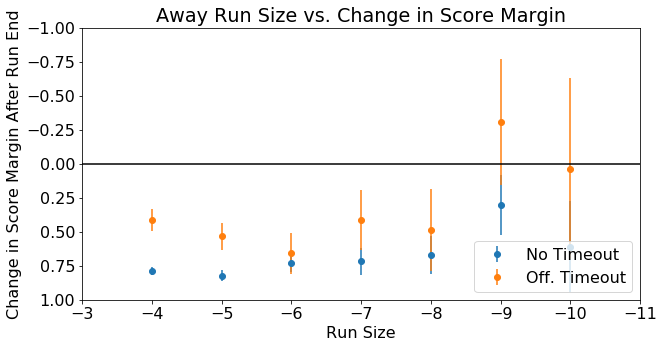

In [41]:
plot_averages(['NoT', 'OT'], np_combined, runner='Away', full_summary=False)

In [42]:
t_test('OT', 'NoT', np_combined, runner='Away', bonferroni=False)

H0: Expected value of Off. Timeout > expected value of No Timeout
HA: Off. Timeout is not signficantly different or worse for the home team than No Timeout
HW: Expected value of Off. Timeout < expected value of No Timeout
--------------------------------------------------------------------
run length | t-stat | H0 p-value |  H0?   | HW p-value |  HW?
--------------------------------------------------------------------
      -4   | -4.356 |    0.000   | Accept |    1.000   | Accept
      -5   | -2.710 |    0.003   | Accept |    0.997   | Accept
      -6   | -0.414 |    0.339   | Accept |    0.661   | Accept
      -7   | -1.256 |    0.105   | Accept |    0.895   | Accept
      -8   | -0.545 |    0.293   | Accept |    0.707   | Accept
      -9   | -1.173 |    0.122   | Accept |    0.878   | Accept
      -10  | -0.761 |    0.225   | Accept |    0.775   | Accept
--------------------------------------------------------------------
 Full Set  | -5.264 |    0.000   | Accept |    1.000   | Acce

## Home/Slipper Timeout

The features are roughly the same as when the home team is the running team and we can draw basically the same conclusion: At best, a timeout by the slipping team is no different 

No Timeout p-value slope is non-zero: 0.065
Home Timeout p-value slope is non-zero: 0.715


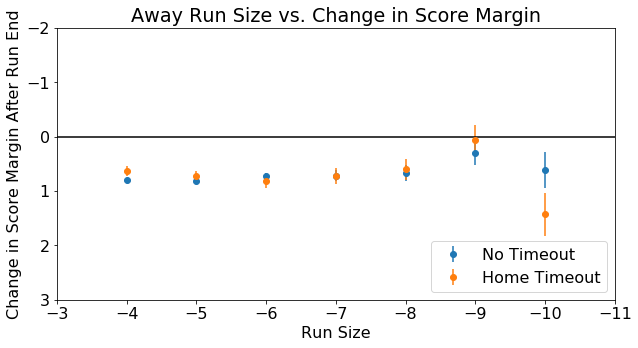

In [43]:
plot_averages(['NoT', 'HT'], np_combined, runner='Away', full_summary=False, ylim=(-2,3))

In [44]:
t_test('HT', 'NoT', np_combined, runner='Away', bonferroni=False)

H0: Expected value of Home Timeout > expected value of No Timeout
HA: Home Timeout is not signficantly different or worse for the home team than No Timeout
HW: Expected value of Home Timeout < expected value of No Timeout
--------------------------------------------------------------------
run length | t-stat | H0 p-value |  H0?   | HW p-value |  HW?
--------------------------------------------------------------------
      -4   | -1.589 |    0.056   | Accept |    0.944   | Accept
      -5   | -0.988 |    0.162   | Accept |    0.838   | Accept
      -6   | +0.664 |    0.746   | Accept |    0.254   | Accept
      -7   | +0.051 |    0.520   | Accept |    0.480   | Accept
      -8   | -0.272 |    0.393   | Accept |    0.607   | Accept
      -9   | -0.666 |    0.253   | Accept |    0.747   | Accept
      -10  | +1.562 |    0.940   | Accept |    0.060   | Accept
--------------------------------------------------------------------
 Full Set  | -1.585 |    0.057   | Accept |    0.943   | Acce

## Away/Runner Timeout

Again, there are very few examples of this case and not much can be said. Away timeouts are statistically significantly worse for the home/slipper, even the outlier at -8 does not fail to reject the null hypothesis, likely due to the high variance and small sample size.

No Timeout p-value slope is non-zero: 0.065
Away Timeout p-value slope is non-zero: 0.511


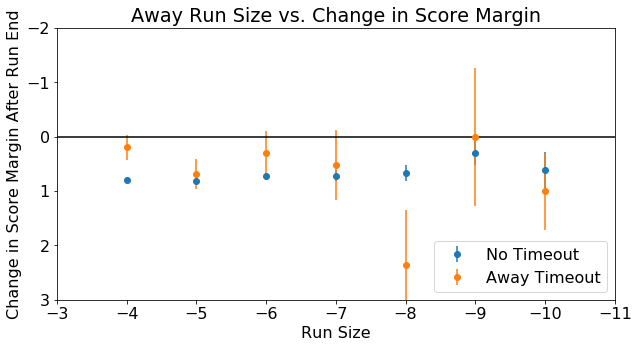

In [45]:
plot_averages(['NoT', 'AT'], np_combined, runner='Away', full_summary=False, ylim=(-2,3))

In [46]:
t_test('AT', 'NoT', np_combined, runner='Away', bonferroni=False)

H0: Expected value of Away Timeout > expected value of No Timeout
HA: Away Timeout is not signficantly different or worse for the home team than No Timeout
HW: Expected value of Away Timeout < expected value of No Timeout
--------------------------------------------------------------------
run length | t-stat | H0 p-value |  H0?   | HW p-value |  HW?
--------------------------------------------------------------------
      -4   | -2.496 |    0.007   | Accept |    0.993   | Accept
      -5   | -0.481 |    0.316   | Accept |    0.684   | Accept
      -6   | -1.039 |    0.152   | Accept |    0.848   | Accept
      -7   | -0.290 |    0.387   | Accept |    0.613   | Accept
      -8   | +1.581 |    0.928   | Accept |    0.072   | Accept
      -9   | -0.214 |    0.419   | Accept |    0.581   | Accept
      -10  | +0.370 |    0.618   | Accept |    0.382   | Accept
--------------------------------------------------------------------
 Full Set  | -2.006 |    0.023   | Accept |    0.977   | Acce

## Conclusions

The aggregate data resoundingly indicate that arbitrary timeouts do not settle players, and in fact, increase the magnitude of a run. We safely reject the hypothesis that timeouts differ from no timeouts, and all of the available evidence indicates that it is far more likely that timeouts hurt the  

This analysis is performed with broad strokes. Coaches know their teams and train them to expect different strategies and timeout usage. Additionally, there are many intangibles involved in a run and the players involved  


The high frequency of timeouts once again complicates the analysis as it seems questionable to consider a timeout effective if multiple are called, but in this work, we ignore this complication and look strictly at the expected point gain/loss.

Thus, Roy Williams should feel vindicated in his refusal to call these timeouts that apparently have the exact opposite effect that fans and coaches seems to think. Not that he needs it with <a href="http://scout.com/college/north-carolina/Bolt/LOOK-UNCs-2017-National-Championship-Rings-107146391">his rings.</a>

## Supplemental Information

I was curious whethere there were any effects of parity on these results (that is, counting the next few scores as an even number or an odd number). To address this concern, I also calculate the same results using the next 3 scores instead of the next 4 scores. There were no noticeable differences.

Similarly, I calculated 5 and 6 scores. The only noticeable effect was a systematic decrease in the size of effects. That is, there is a general regression to zero average score margin as the post sequence length increases. This can be examined by altering the "scores" parameter in the "find_sequence_value" function.

The three score results are shown with their 4 score counterparts and indicated with "-1". These values are automatically calculated, so changing "scores" in find_sequence_value will automtically generate the "less one" sequences.

No Timeout p-value slope is non-zero: 0.251
NoT-1 p-value slope is non-zero: 0.172


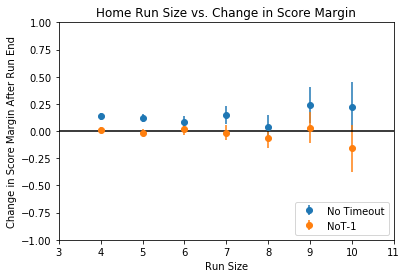

No Timeout p-value slope is non-zero: 0.065
NoT-1 p-value slope is non-zero: 0.119


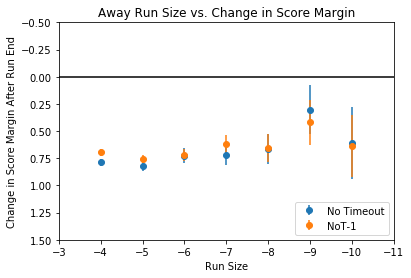

Off. Timeout p-value slope is non-zero: 0.193
OT-1 p-value slope is non-zero: 0.507


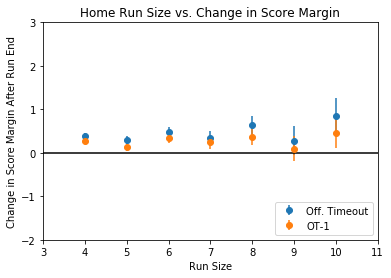

Off. Timeout p-value slope is non-zero: 0.089
OT-1 p-value slope is non-zero: 0.120


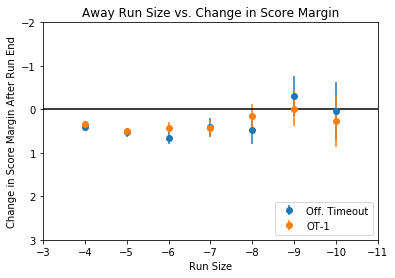

Away Timeout p-value slope is non-zero: 0.293
AT-1 p-value slope is non-zero: 0.541


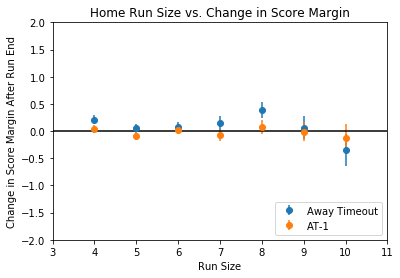

Away Timeout p-value slope is non-zero: 0.511
AT-1 p-value slope is non-zero: 0.678


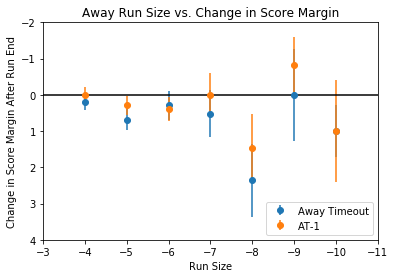

Home Timeout p-value slope is non-zero: 0.114
HT-1 p-value slope is non-zero: 0.090


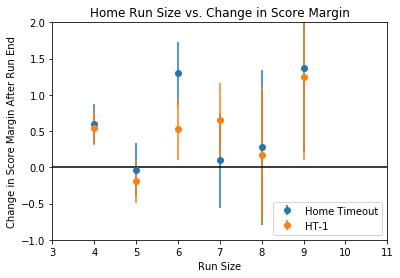

Home Timeout p-value slope is non-zero: 0.715
HT-1 p-value slope is non-zero: 0.541


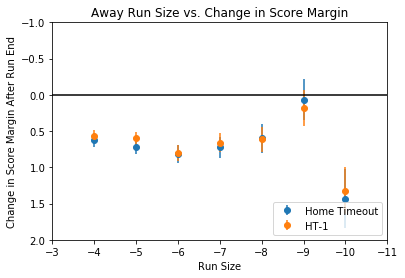

In [25]:
#plot_averages(seq_values.keys(), np_combined) # Universally biases towards away team as expected
plot_averages(['NoT', 'NoT-1'], np_combined, runner='Home')
plt.show()
plot_averages(['NoT', 'NoT-1'], np_combined, runner='Away', ylim=(-0.5,1.5))
plt.show()
plot_averages(['OT', 'OT-1'], np_combined, runner='Home', ylim=(-2,3))
plt.show()
plot_averages(['OT', 'OT-1'], np_combined, runner='Away', ylim=(-2,3))
plt.show()
plot_averages(['AT', 'AT-1'], np_combined, runner='Home', ylim=(-2,2))
plt.show()
plot_averages(['AT', 'AT-1'], np_combined, runner='Away', ylim=(-2,4))
plt.show()
plot_averages(['HT', 'HT-1'], np_combined, runner='Home', ylim=(-1,2))
plt.show()
plot_averages(['HT', 'HT-1'], np_combined, runner='Away', ylim=(-1,2))
plt.show()

In [26]:
import itertools
# Every combinations
#combos = list(itertools.combinations(seq_values.keys(),2))
combos = [('NoT', 'NoT-1'), ('AT', 'AT-1'), ('HT', 'HT-1'), ('OT', 'OT-1'), ('AT', 'NoT-1'), ('AT-1', 'NoT')]
for runner in ['Home', 'Away']:
    for combo in combos:
        t_test(combo[0], combo[1], np_combined, runner=runner)
        print()


H0: Expected value of No Timeout < expected value of NoT-1
HA: No Timeout is not signficantly different or worse for the away team than NoT-1
HW: Expected value of No Timeout > expected value of NoT-1
--------------------------------------------------------------------
run length | t-stat | H0 p-value |  H0?   | HW p-value |  HW?
--------------------------------------------------------------------
      4    | +3.288 |    0.999   | Reject |    0.001   | Accept
      5    | +2.678 |    0.996   | Reject |    0.004   | Accept
      6    | +0.912 |    0.819   | Reject |    0.181   | Reject
      7    | +1.542 |    0.938   | Reject |    0.062   | Reject
      8    | +0.784 |    0.783   | Reject |    0.217   | Reject
      9    | +0.938 |    0.826   | Reject |    0.174   | Reject
      10   | +1.199 |    0.884   | Reject |    0.116   | Reject
--------------------------------------------------------------------
 Full Set  | +4.744 |    1.000   | Reject |    0.000   | Accept

H0: Expected valu

UnboundLocalError: local variable 'p_null' referenced before assignment

In [ ]:
plt.hist(np_combined[(10,'AT')], bins=16)
print(len(np_combined[(10,'AT')]))
plt.show()
plt.hist(np_combined[(10,'NoT')], bins=16)
print(len(np_combined[(10,'NoT')]))
plt.show()

In [ ]:
plot_averages(['NoT', 'ZT'], np_combined, full_summary=False)

In [ ]:
plot_averages(['NoT', 'ZT'], np_combined, runner='Away', full_summary=False, ylim=(-2,2))

In [ ]:
t_test('NoT','ZT', np_combined, runner='Away')

note that every sequence is considered, and only the terminal event is used to divide the sequences into categories. We are trying to determine the expected value of calling a timeout at a particular moment in time, absent any knowledge of future events. This means that every subsequence of a long run is also considered. As an example, we look at one of the above sequences:

H3H3H3 H2 **AT** H2 A2 H2 A3

will be scored as an 11 point home run that is terminated in an away timeout with a change in margin of -1 (away team expected to gain 1 point from this timeout).

However, the sequence

H3H3H3 **H2** AT H2 A2 H2

also needs to be considered because we need to know the expected value of not calling a timeout after 9 home points. In this case, we would score home run 9 with expected change in margin of +4 (terminal event is included in the minimum 4 scores). These sequences would not be compared directly. The first would be compared with other sequences that were valued at 11 points and the second would be compared with sequences valued at 9 points. In this way, we would expect to see a difference between sequences where the timeout was called after 9 points and 11 points.

In [ ]:
# Nice little alert to let me know when the Notebook has finished
from IPython.display import HTML
HTML('''<script>
alert('Done!')
</script>''')